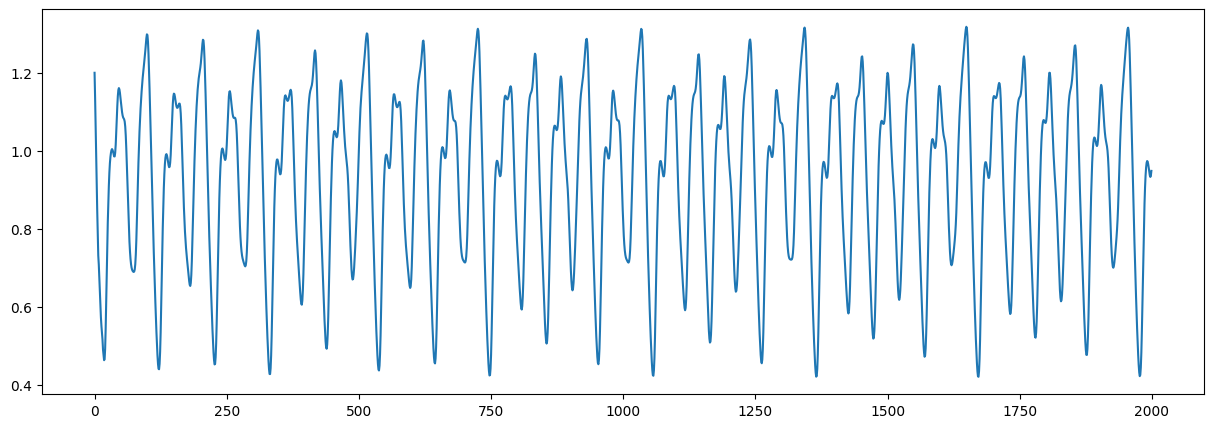

In [1]:
from reservoirpy.datasets import mackey_glass
import pylab as plt

time_steps = 2000
time_series = mackey_glass(time_steps)

fig, ax = plt.subplots(figsize=(15, 5))
ax.plot(time_series)
plt.show()

In [2]:
from sklearn.model_selection import train_test_split
from lstm import make_windows

in_size = 16  # (4, 8, 16)
out_size = 70  # (1, 70, 140)
X, Y = make_windows(time_series, in_size=in_size, out_size=out_size)

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, shuffle=False)

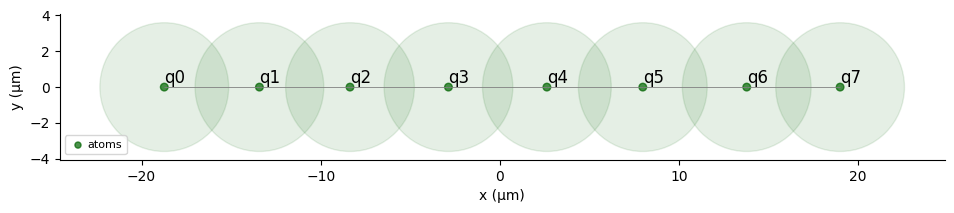

In [3]:
from itertools import accumulate
import numpy as np
from pulser import AnalogDevice, Register

device = AnalogDevice

num_atoms = 8
distances = 6 - np.random.uniform(low=0, high=1, size=num_atoms-1)
coords = [(0.0, 0.0)]
coords += [(x, 0.0) for x in accumulate(distances)]
reg = Register.from_coordinates(coords=coords, prefix="q").with_automatic_layout(device)

rabi_frequency = 2*np.pi
blockade_radius = device.rydberg_blockade_radius(rabi_frequency)
reg.draw(blockade_radius=blockade_radius, draw_half_radius=True)

In [4]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler

x_scaler = MinMaxScaler(feature_range=(0.5, 2*np.pi))
y_scaler = MinMaxScaler(feature_range=(0.5, 2*np.pi))

X_train = x_scaler.fit_transform(X_train.reshape(X_train.shape[0], -1)).reshape(X_train.shape) 
X_test = x_scaler.transform(X_test.reshape(X_test.shape[0], -1)).reshape(X_test.shape)
Y_train = y_scaler.fit_transform(Y_train)
Y_test = y_scaler.transform(Y_test)

In [5]:
from pulser import Sequence, Pulse
from pulser import InterpolatedWaveform, ConstantWaveform, CompositeWaveform

seq = Sequence(register=reg, device=device)
duration = 6000

rabi_frequency = device.rabi_from_blockade(blockade_radius)
amplitude = CompositeWaveform(
    ConstantWaveform(duration=0.6*duration, value=rabi_frequency),
    ConstantWaveform(duration=0.4*duration, value=0)
)

deltas = seq.declare_variable(name="deltas", size=in_size)
detuning = InterpolatedWaveform(duration=duration, values=deltas)

pulse = Pulse(amplitude=amplitude, detuning=detuning, phase=0.0)
seq.declare_channel(name="ch", channel_id="rydberg_global")
seq.add(pulse=pulse, channel="ch")

In [6]:
import qutip
from itertools import combinations

n = len(reg.qubits)
id = qutip.qeye(2)
z = qutip.sigmaz()

Z_ops = []
for i in range(n):
    op_list = [z if k == i else id for k in range(n)]
    Z_ops.append(qutip.tensor(op_list))

ZZ_ops = []
for i, j in combinations(range(n), 2):
    op_list = [z if k == i or k == j else id for k in range(n)]
    ZZ_ops.append(qutip.tensor(op_list))

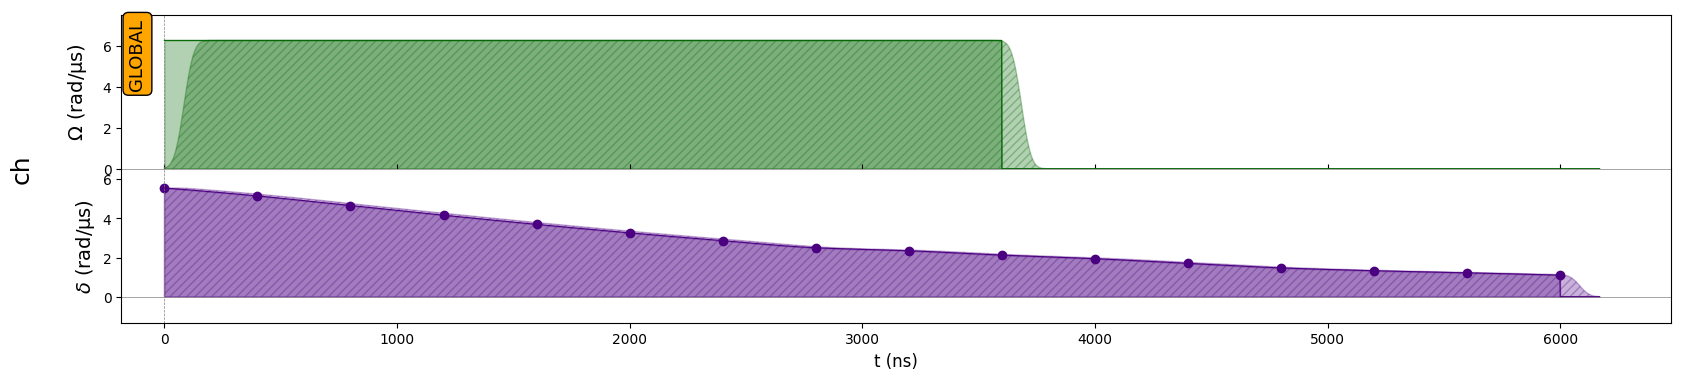

In [7]:
sequences_train = [seq.build(deltas=x[:, 0]) for x in X_train]
sequences_test = [seq.build(deltas=x[:, 0]) for x in X_test]

sequences_train[0].draw()

In [8]:
import os
from contextlib import redirect_stdout
from pulser.backends import QutipBackendV2
import numpy as np
from tqdm import tqdm

expvals_train = []
for seq in tqdm(sequences_train, desc="Measure expvals (train)"):
    backend = QutipBackendV2(seq)
    with open(os.devnull, "w") as f, redirect_stdout(f):
        result = backend.run()
    state = result.final_state.to_qobj()
    expvals = [qutip.expect(op, state) for op in Z_ops + ZZ_ops]
    expvals_train.append(expvals)

expvals_test = []
for seq in tqdm(sequences_test, desc="Measure expvals (test)"):
    backend = QutipBackendV2(seq)
    with open(os.devnull, "w") as f, redirect_stdout(f):
        result = backend.run()
    state = result.final_state.to_qobj()
    expvals = [qutip.expect(op, state) for op in Z_ops + ZZ_ops]
    expvals_test.append(expvals)

expvals_train = np.array(expvals_train)
expvals_test = np.array(expvals_test)

Measure expvals (test): 100%|██████████| 575/575 [00:59<00:00,  9.61it/s]


In [9]:
import jax
import jax.numpy as jnp
from flax import linen as nn
from flax.training.train_state import TrainState

class OneLayerModel(nn.Module):
    out_size: int

    @nn.compact
    def __call__(self, x):
        return nn.Dense(self.out_size)(x)

def create_train_state(rng, model, optimizer, in_size):
    params = model.init(rng, jnp.ones((1, in_size), dtype=jnp.float32))
    return TrainState.create(apply_fn=model.apply, params=params, tx=optimizer)

def loss_fn(params, apply_fn, x_batch, y_batch):
    pred = apply_fn(params, x_batch)
    return jnp.mean((pred - y_batch) ** 2)

@jax.jit
def train_step(state, x_batch, y_batch):
    loss, grads = jax.value_and_grad(loss_fn)(
        state.params, state.apply_fn, x_batch, y_batch
    )
    state = state.apply_gradients(grads=grads)
    return state, loss

@jax.jit
def eval_step(state, x_batch, y_batch):
    return loss_fn(state.params, state.apply_fn, x_batch, y_batch)

In [22]:
import optax

rng = jax.random.PRNGKey(0)
model = OneLayerModel(out_size=out_size)
learning_rate = 0.05
optimizer = optax.adam(learning_rate=learning_rate)
num_features = len(Z_ops) + len(ZZ_ops)
state = create_train_state(rng, model, optimizer, in_size=num_features)

batch_size = 32
epochs = 300
num_train = X_train.shape[0]
train_mse_history = []
test_mse_history = []
X_train_feat = np.asarray(expvals_train, dtype=np.float32)
Y_train_target = np.asarray(Y_train, dtype=np.float32)
X_test_feat = np.asarray(expvals_test, dtype=np.float32)
Y_test_target = np.asarray(Y_test, dtype=np.float32)
for epoch in range(epochs):
    perm = np.random.permutation(num_train)
    train_losses = []
    for i in range(0, num_train, batch_size):
        batch_idx = perm[i:i + batch_size]
        xb = jnp.asarray(X_train_feat[batch_idx])
        yb = jnp.asarray(Y_train_target[batch_idx])
        state, loss = train_step(state, xb, yb)
        train_losses.append(float(loss))
    train_mse = float(np.mean(train_losses))
    test_mse = float(eval_step(state, jnp.asarray(X_test_feat), jnp.asarray(Y_test_target)))
    train_mse_history.append(train_mse)
    test_mse_history.append(test_mse)

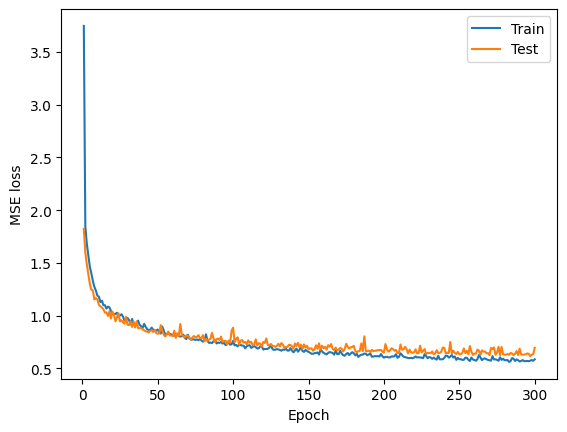

In [23]:
fig, ax = plt.subplots()
ax.plot(np.arange(1, epochs + 1), train_mse_history, label="Train")
ax.plot(np.arange(1, epochs + 1), test_mse_history, label="Test")
ax.set_xlabel("Epoch")
ax.set_ylabel("MSE loss")
ax.legend()
plt.show()

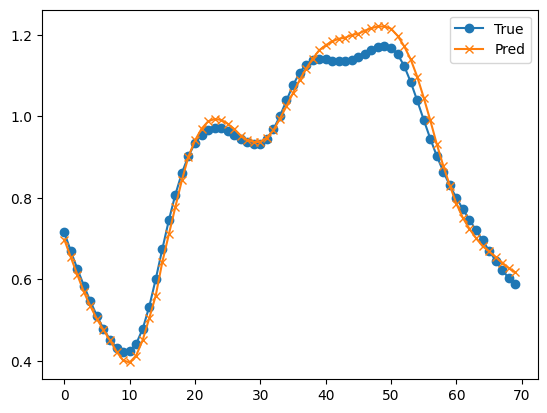

In [24]:
pred_test = np.array(state.apply_fn(state.params, jnp.asarray(X_test_feat)))
pred_test = y_scaler.inverse_transform(pred_test)
Y_test_raw = y_scaler.inverse_transform(Y_test_target)

idx = 0
true_horizon = Y_test_raw[idx]
pred_horizon = pred_test[idx]

fig, ax = plt.subplots()
ax.plot(np.arange(out_size), true_horizon, marker="o", label="True")
ax.plot(np.arange(out_size), pred_horizon, marker="x", label="Pred")
ax.legend()
plt.show()